This is a work in progress, an attempt to aid in understanding morphological openings and fourier transforms of imagery.

In [127]:
from scipy import ndimage, signal, spatial, interpolate
from scipy.ndimage import morphology

import numpy as np
import pandas as pd
import pdal

import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

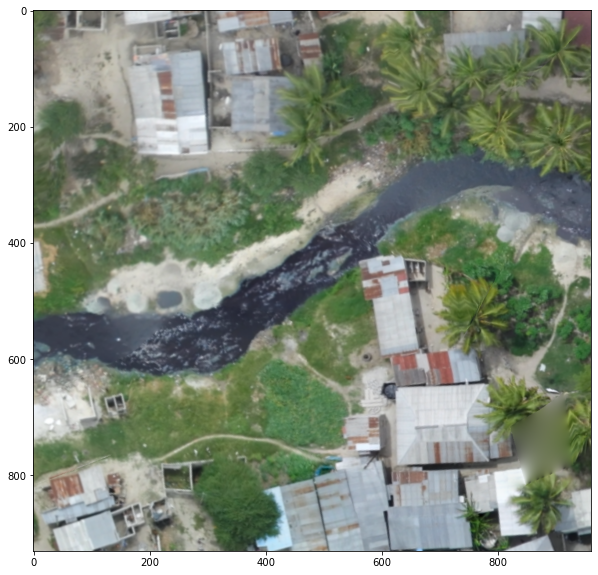

In [137]:
from osgeo import gdal
raster = gdal.Open(r"E:\IG\ctc_msimbazi.tif")
band1 = raster.GetRasterBand(1) # Red channel
band2 = raster.GetRasterBand(2) # Green channel
band3 = raster.GetRasterBand(3) # Blue channel
b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()
img = np.dstack((b1, b2, b3))
f = plt.figure(figsize=(10,10))

plt.imshow(img)
plt.show()

orthophoto for visual reference only

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [9]:
data_in = r"E:\IG\cropped_thinned_cropped.las"

#readin in full res .las , subsampled with Poisson, change radius to reach desired resolution
p = pdal.Reader.las(data_in).pipeline()
n_points = p.execute()
f'Pipeline selected {n_points} points'

'Pipeline selected 5173 points'

In [10]:
#create a one dimensional array from the "Classification" column
cls = p.arrays[0]['Classification']
#set the array to all ones
cls.fill(1)

In [11]:
#convert X,Y, and Z data to a pandas dataframe
df3D = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

In [12]:
#define variables (if we keep k = 0, then I'll clean up the code, remove gstar?)
S = 20
k = 0.000
n = 0.1
b = -0.2

In [13]:
#can't find any documentation on .ptp(), but it must be the x and y length for computing the area
density = n_points / (p.arrays[0]['Y'].ptp() * p.arrays[0]['X'].ptp())
#hres = 1. / density
#override calculated hres and setting it to 0.25 m

#this setting should be relative to point density, but the above method "1./density" is not the way to go.

hres = 1

In [14]:
print("Point cloud density estimated as", density, "pts/m^2. Processing at", hres, "m resolution.")

Point cloud density estimated as 1.2515711951918727 pts/m^2. Processing at 1 m resolution.


In [15]:
dfvis = pd.DataFrame(p.arrays[0])

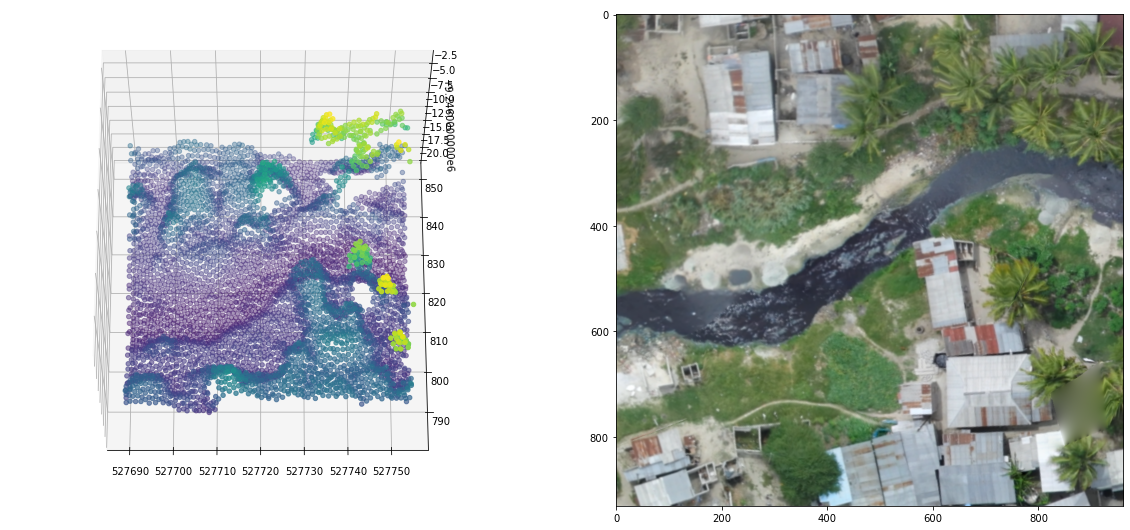

In [145]:
fig = plt.figure(figsize=(20,10))
#plt.subplot(1,2,1)
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(dfvis.X, dfvis.Y, dfvis.Z, c=dfvis.Z, cmap='viridis')
ax.view_init(65, 270)
ax.axis('tight')
plt.subplot(1,2,2)
plt.imshow(img)
#plt.show()

In [18]:
#np.ogrid "open-grid", creates a way to index the matrix (access pixels/pts) hres is the step
xi = np.ogrid[p.arrays[0]['X'].min():p.arrays[0]['X'].max():hres]
yi = np.ogrid[p.arrays[0]['Y'].min():p.arrays[0]['Y'].max():hres]

In [19]:
#np.digitize allocates points to bins and then bins are grouped in the df
bins = df3D.groupby([np.digitize(p.arrays[0]['X'], xi), np.digitize(p.arrays[0]['Y'], yi)])

In [20]:
#figure out a way to plot pointcloud based on group coloring

gb = bins.groups
gb

{(1, 1): [5142], (1, 3): [5143, 5144, 5145], (1, 4): [5146], (1, 5): [5147, 5148], (1, 7): [5149], (1, 8): [5150], (1, 9): [5151], (1, 11): [5152], (1, 12): [5153], (1, 15): [5154], (1, 17): [5155], (1, 21): [5156], (1, 22): [5157], (1, 24): [5158], (1, 25): [5159], (1, 27): [5160], (1, 28): [5161], (1, 30): [5162], (1, 32): [5163], (1, 33): [5164], (1, 35): [5165], (1, 36): [5166], (1, 37): [5167], (1, 39): [5168], (1, 40): [5169], (1, 41): [5170], (1, 44): [5171], (1, 46): [5172], (1, 49): [1065], (1, 50): [1064], (1, 51): [1071], (1, 52): [1062, 1073], (1, 53): [1059, 1072], (1, 54): [1056, 1074], (1, 55): [1057], (1, 56): [1067], (1, 57): [1066], (1, 58): [1069], (1, 59): [1061, 1063], (1, 60): [1070], (1, 61): [1060], (1, 62): [1068], (1, 63): [1058], (2, 1): [266], (2, 2): [311, 350], (2, 3): [382], (2, 4): [416, 432], (2, 5): [474, 513], (2, 6): [531, 573], (2, 7): [601, 657], (2, 8): [702], (2, 9): [769], (2, 10): [829], (2, 11): [865, 899], (2, 12): [933], (2, 13): [1312, 1372

In [21]:
zmins = bins.Z.min() #collects the lowest point in each bin
cz = np.empty((yi.size, xi.size)) #create empty 2d array 
cz.fill(np.nan) #fill 2d array with nan
for name, val in zmins.items():
    #print(name[1],name[0],val)
    cz[name[1]-1, name[0]-1] = val #adding coordinates to lowest points only(not sure why -1 is used here)

In [22]:
cz

array([[-14.735001, -14.175   , -14.435   , ..., -13.405001, -14.365001,
               nan],
       [       nan, -14.165001,        nan, ..., -13.645   , -13.045   ,
        -11.805   ],
       [-15.695001, -13.345   , -13.655001, ..., -13.335001, -13.355   ,
        -12.775001],
       ...,
       [-12.955001, -14.085001, -14.815   , ..., -13.895   , -13.695001,
               nan],
       [       nan, -14.275001,        nan, ..., -14.055   , -13.925   ,
        -13.045   ],
       [       nan,        nan,        nan, ...,        nan, -13.845   ,
               nan]])

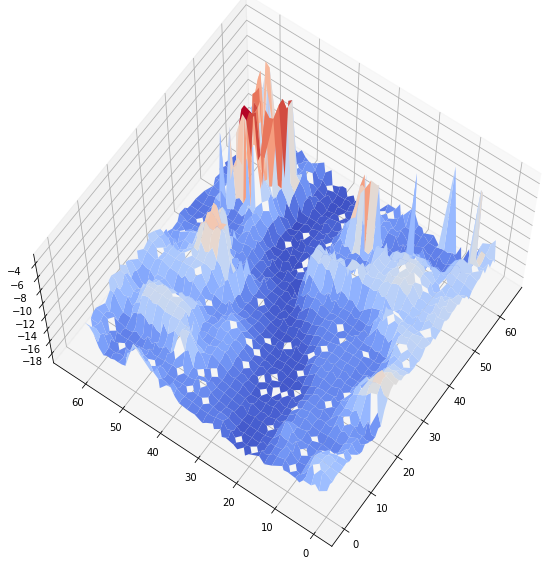

In [25]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,cz,cmap=cm.coolwarm)


In [26]:
x,y =cz.shape
x,y,hres

major = np.arange(0,x,hres*10)
minor = np.arange(0,x,hres)

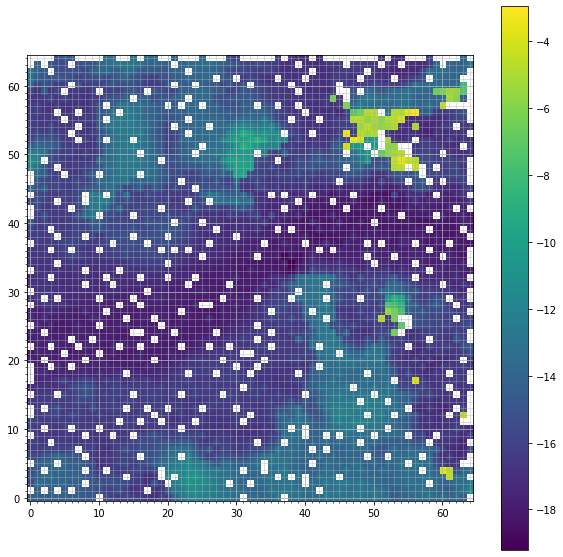

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.set_xticks(major)
ax.set_xticks(minor,minor=True)
#ax.set_yticks(major)
ax.set_yticks(minor,minor=True)

#ax.grid(which='both')

ax.grid(which='minor', alpha=0.5)
#ax.grid(which='major', alpha=1)

plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

In [28]:
def idw(data):
    # Find indices of the ground returns, i.e., anything that is not a nan, and create a KD-tree.
    # We will search this tree when looking for nearest neighbors to perform the interpolation.
    valid = np.argwhere(~np.isnan(data))
    tree = spatial.cKDTree(valid)
    
    # Now find indices of the non-ground returns, as indicated by nan values. We will interpolate
    # at these locations.
    nans = np.argwhere(np.isnan(data))    
    for row in nans:
        d, idx = tree.query(row, k=12)
        d = np.power(d, -2)
        v = data[valid[idx, 0], valid[idx, 1]]
        data[row[0], row[1]] = np.inner(v, d)/np.sum(d)
        
    return data

In [29]:
%%time
cz = idw(cz)

Wall time: 22 ms


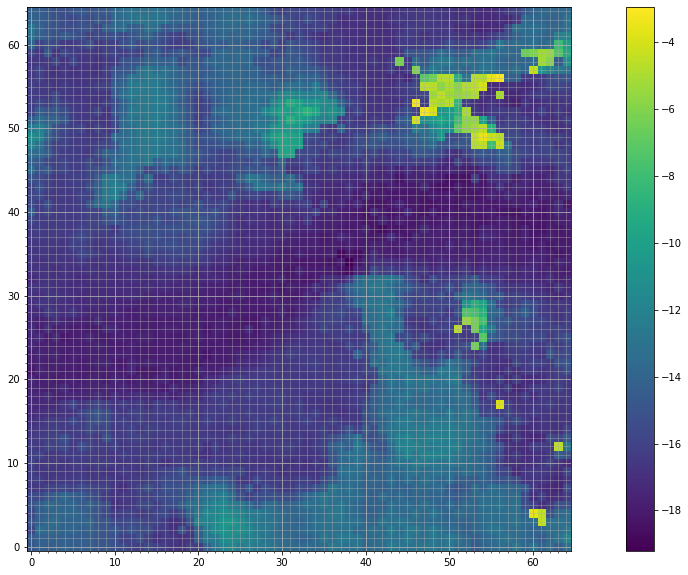

In [30]:
fig, ax = plt.subplots(figsize=(20,10))

#ax.set_xticks(major)
ax.set_xticks(minor,minor=True)
#ax.set_yticks(major)
ax.set_yticks(minor,minor=True)

#ax.grid(which='both')

ax.grid(which='minor', alpha=0.5)
#ax.grid(which='major', alpha=1)

plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

https://www.youtube.com/watch?v=E_vU1Wd7Ks8&ab_channel=JianWeiTay

In [147]:
#create an initial diamond structure 2,1 and enlarge it 11 times = 23x,23y
#does this structoring element size have any corelation to point density,cloud features or binsize?

struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
opened = morphology.grey_opening(cz, structure=struct) #opening = Erosion -> Dilation

#morphological opening is useful to smooth objects and remove noise

In [148]:
struct

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

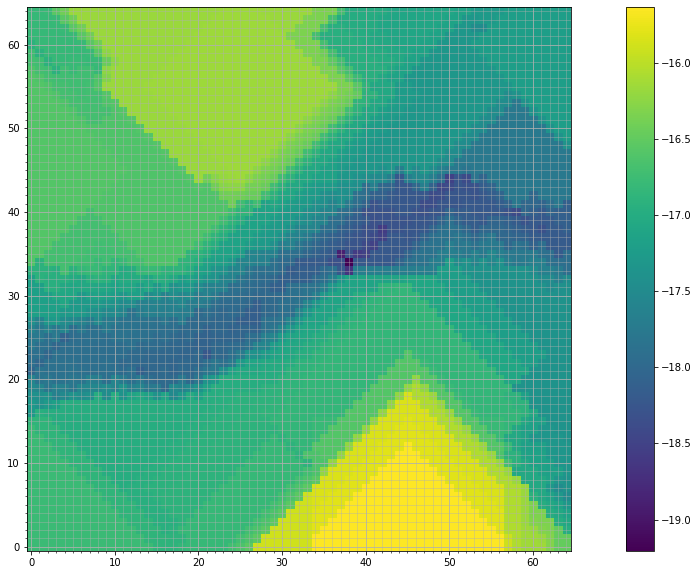

In [33]:
fig, ax = plt.subplots(figsize=(20,10))

#ax.set_xticks(major)
ax.set_xticks(minor,minor=True)
#ax.set_yticks(major)
ax.set_yticks(minor,minor=True)

#ax.grid(which='both')

ax.grid(which='minor', alpha=0.5)
#ax.grid(which='major', alpha=1)

plt.imshow(opened, origin='lower'); plt.colorbar(); ax.grid()

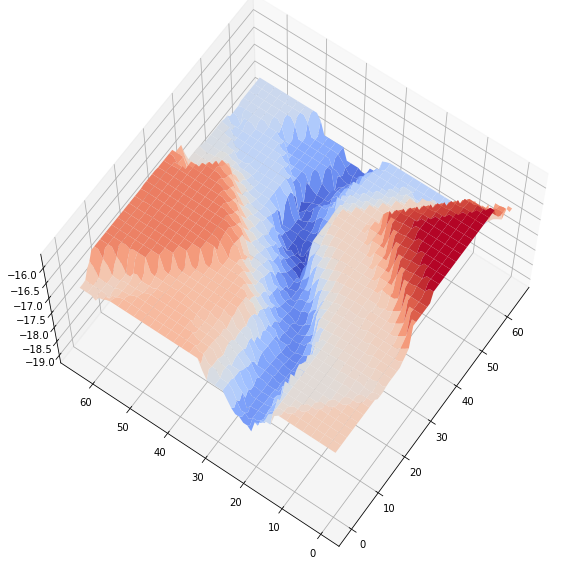

In [36]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,opened,cmap=cm.coolwarm)

In [35]:
#create another plus-shaped (2,1) and enlarge it 9 times = 19x,19y
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
closed = morphology.grey_closing(opened, structure=struct) #closing = dilation -> erosion

#closing is useful for filling in small holes while preserving shape and size of objects

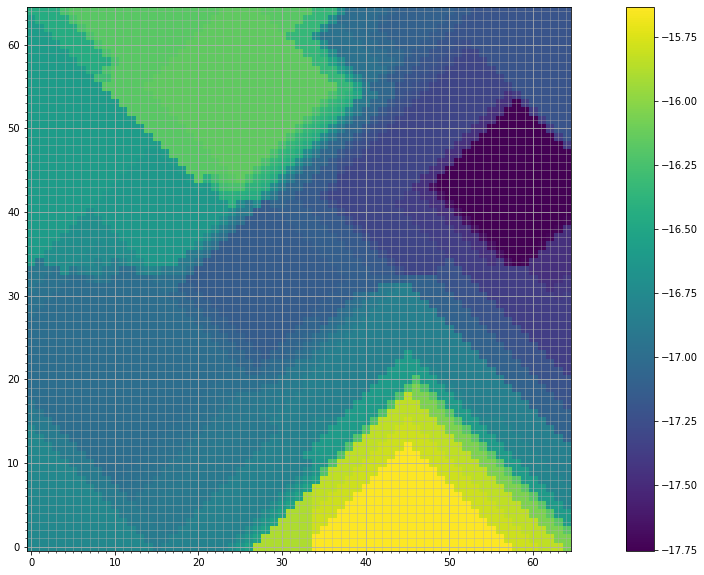

In [37]:

fig, ax = plt.subplots(figsize=(20,10))

#ax.set_xticks(major)
ax.set_xticks(minor,minor=True)
#ax.set_yticks(major)
ax.set_yticks(minor,minor=True)

#ax.grid(which='both')

ax.grid(which='minor', alpha=0.5)
#ax.grid(which='major', alpha=1)

plt.imshow(closed, origin='lower'); plt.colorbar(); ax.grid()

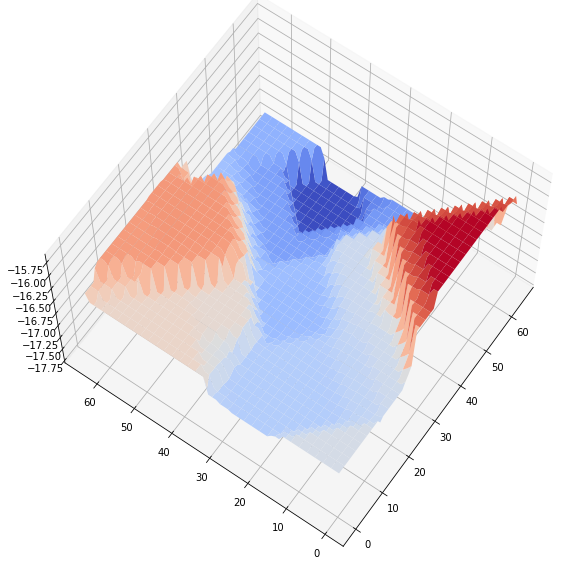

In [39]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,closed,cmap=cm.coolwarm)

In [40]:
#removing low outliers: if any pt in cz is >= 1 meter below the surface of closed then it is set to the 
#closed surface value
#need to test lower limit >= 0.5
lowx, lowy = np.where((closed - cz) >= 1.0) 
cz[lowx, lowy] = closed[lowx, lowy]

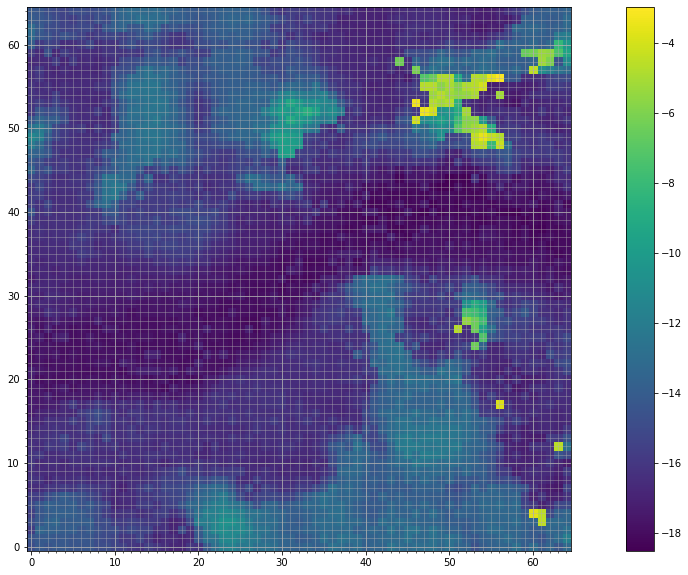

In [41]:
#there are no low outliers in this data

fig, ax = plt.subplots(figsize=(20,10))

#ax.set_xticks(major)
ax.set_xticks(minor,minor=True)
#ax.set_yticks(major)
ax.set_yticks(minor,minor=True)

#ax.grid(which='both')

ax.grid(which='minor', alpha=0.5)
#ax.grid(which='major', alpha=1)

plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

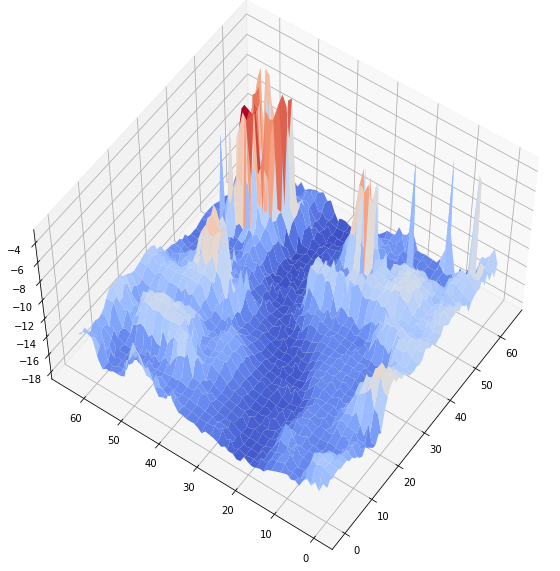

In [43]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(55, 215)
ha.plot_surface(X,Y,cz,cmap=cm.coolwarm)

In [44]:
stdev = 14

#product of two guassian arrays with the max normalized to 1, size/window = 113
#the size of the gaussian kernel must be large enough to remove all non-ground features (bigger than the largest building)
#should kernel size be scaled to bin size? Current kernel size works great with 1 meter bin
#.5m bin should have 226 kernel? .25m bin / 452? would also need to increase stdev with bigger kernel

G = np.outer(signal.gaussian(113,stdev), signal.gaussian(113,stdev))

#fast fourier transform convolution, matrix is padded at 2*stdev
low = signal.fftconvolve(np.pad(cz,2*stdev,'edge'), G, mode='same')[2*stdev:-2*stdev,2*stdev:-2*stdev]/1000.

In [45]:
G.shape

(113, 113)

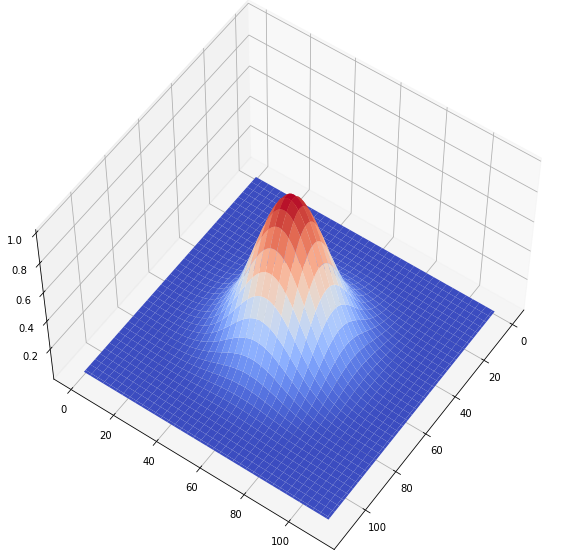

In [46]:
nx,ny =G.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(55, 35)
ha.plot_surface(X,Y,G,cmap=cm.coolwarm)

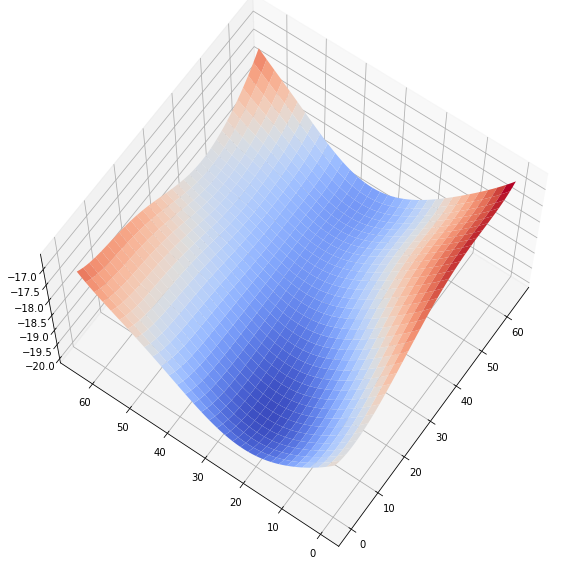

In [48]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,low,cmap=cm.coolwarm)

In [49]:
%%time
high = cz - low

Wall time: 0 ns


In [50]:
high.shape

(65, 65)

In [51]:
high[0]

array([3.42843937, 4.04063528, 3.8226497 , 4.11529724, 4.12929569,
       3.905319  , 3.96396406, 4.01577203, 3.52121849, 3.54074212,
       3.05402165, 2.78358073, 2.26759433, 2.02710628, 2.65242632,
       2.12385616, 1.74170349, 1.28627598, 1.18788923, 1.99686873,
       1.71354574, 3.7782673 , 4.9913864 , 5.88326043, 6.10425908,
       5.32474777, 5.43509576, 4.75566812, 4.81682353, 4.48877663,
       3.88203361, 3.71366486, 3.5736919 , 3.7226676 , 3.39408949,
       3.58818958, 4.31517496, 4.0406442 , 3.67810081, 3.96440684,
       3.16404106, 3.43703852, 3.44338788, 4.2830459 , 3.82592019,
       3.63188295, 3.9207588 , 3.86232874, 4.05632914, 3.55244688,
       4.0303235 , 3.40955541, 3.21968423, 2.13020609, 2.85056503,
       3.14015748, 3.3383268 , 3.25436297, 3.98751105, 2.88695541,
       3.80183696, 2.68124248, 3.27421472, 2.27975151, 3.40561321])

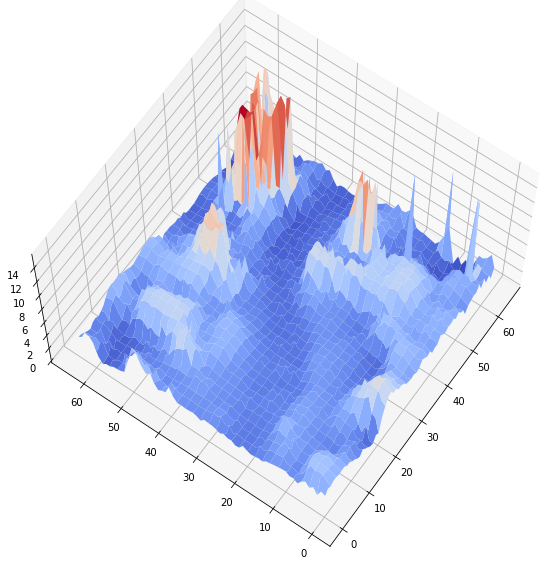

In [53]:
nx,ny =cz.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,high,cmap=cm.coolwarm)

flattening structure defined by size=3:

 https://www.mathworks.com/help/images/structuring-elements.html#:~:text=A%20flat%20structuring%20element%20is,in%20the%20image%20being%20processed.

greyscale erosion: https://en.wikipedia.org/wiki/Erosion_%28morphology%29, https://www.youtube.com/watch?v=yM0tqRhpxoM&ab_channel=JianWeiTay

In [55]:
%%time
erosions = []
granulometry = []
erosions.append(morphology.grey_erosion(high, size=3))

#trying to come up with a way to visualize the grey erosion on high
nper = np.asarray(erosions)
nper.shape


Wall time: 500 µs


(1, 65, 65)

In [56]:
arr1 = nper[0][0]
arr1

array([3.42843937, 3.42843937, 3.8226497 , 3.8226497 , 3.905319  ,
       3.905319  , 3.905319  , 3.52121849, 3.45710778, 3.05402165,
       2.42050993, 2.26759433, 2.02710628, 2.02710628, 1.40218295,
       1.40218295, 1.28627598, 1.18788923, 1.18788923, 1.18788923,
       1.50668477, 1.71354574, 3.7782673 , 4.9913864 , 5.32474777,
       5.32474777, 4.75566812, 4.62740647, 4.45904659, 3.88203361,
       3.71366486, 3.2624983 , 3.2624983 , 3.2624983 , 3.36083086,
       3.39408949, 3.58818958, 3.67810081, 3.67810081, 3.16404106,
       3.16404106, 3.16404106, 3.42892391, 3.44338788, 3.63188295,
       3.63188295, 3.63188295, 3.69125267, 3.55244688, 3.55244688,
       3.40955541, 3.00913946, 2.13020609, 2.13020609, 2.13020609,
       2.85056503, 3.14015748, 3.25436297, 2.88695541, 2.78692564,
       2.33717888, 2.33717888, 2.27975151, 2.27975151, 2.27975151])

In [57]:
nper[0][64]

array([2.92442379, 2.58859864, 2.28489453, 2.0947362 , 1.90505875,
       1.90505875, 1.90505875, 2.27861169, 2.27861169, 2.65054463,
       2.65054463, 3.72843832, 4.24694773, 4.44612898, 4.44612898,
       4.20197641, 3.78994478, 3.78994478, 3.59799735, 3.44291367,
       3.44291367, 3.44291367, 3.67835155, 3.89750682, 4.13266902,
       4.30017161, 4.00969077, 3.37270708, 2.46318115, 1.9870226 ,
       1.9870226 , 1.9870226 , 2.2216099 , 2.2216099 , 2.13877078,
       2.13877078, 1.42996621, 1.42996621, 1.42996621, 1.4694271 ,
       1.4694271 , 1.43420507, 1.43420507, 1.43420507, 1.64435004,
       1.82125082, 1.89706639, 1.85131032, 1.74614919, 1.56629809,
       1.30922859, 1.2450443 , 0.97144841, 0.85591952, 0.85591952,
       0.85591952, 0.78174141, 0.78174141, 0.78174141, 1.38059382,
       3.00849191, 3.52516301, 3.52516301, 3.52516301, 3.54750512])

In [58]:
new = nper.reshape(65,65)

In [59]:
new.shape

(65, 65)

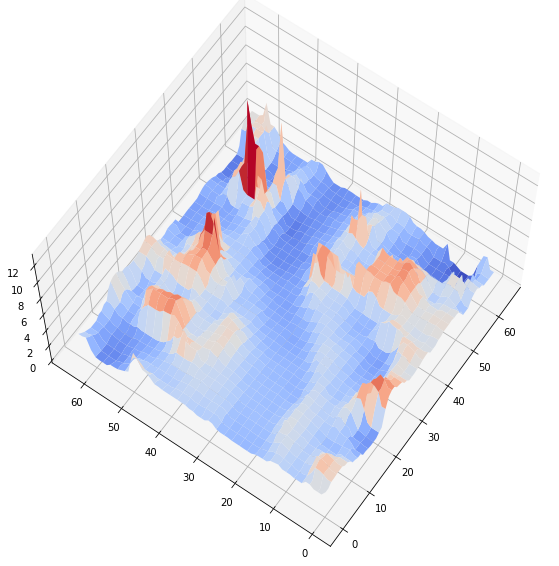

In [61]:
nx,ny =new.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(65, 215)
ha.plot_surface(X,Y,new,cmap=cm.coolwarm)

In [62]:
for scale in range(1, S):
    erosions.append(morphology.grey_erosion(erosions[scale-1], size=3))
for scale in range(1, S+1):
    granulometry.append(morphology.grey_dilation(erosions[scale-1], size=2*scale+1))

In [63]:
%%time
out = []
for i in range(1, len(granulometry)):
    out.append(granulometry[i-1]-granulometry[i])

Wall time: 500 µs


In [64]:
%%time
gprime = np.maximum.reduce(out)
xs, ys = out[0].shape
gstar = np.zeros((xs,ys))
gplus = np.zeros((xs,ys))
for ii in range(0,xs):
    for jj in range(0,ys):
        for kk in range(0,len(out)):
            if out[kk][ii,jj] < gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
            if out[kk][ii,jj] == gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
                gstar[ii,jj] = kk
                break

Wall time: 27 ms


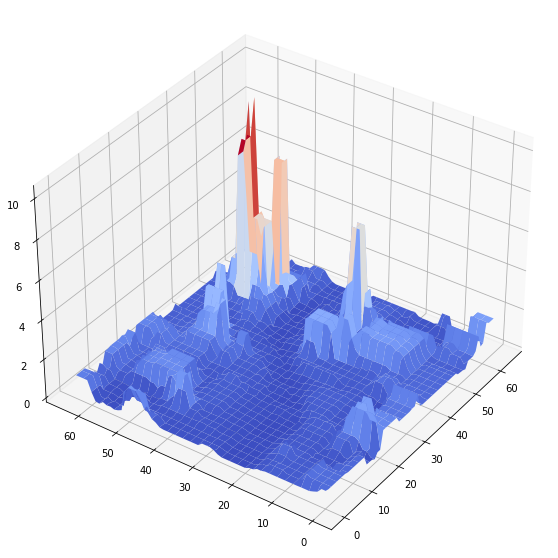

In [115]:
nx,ny =gprime.shape
x = range(nx)
y = range(ny)


hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,gprime,cmap=cm.coolwarm)

Text(0.5, 1.0, '$g^+$')

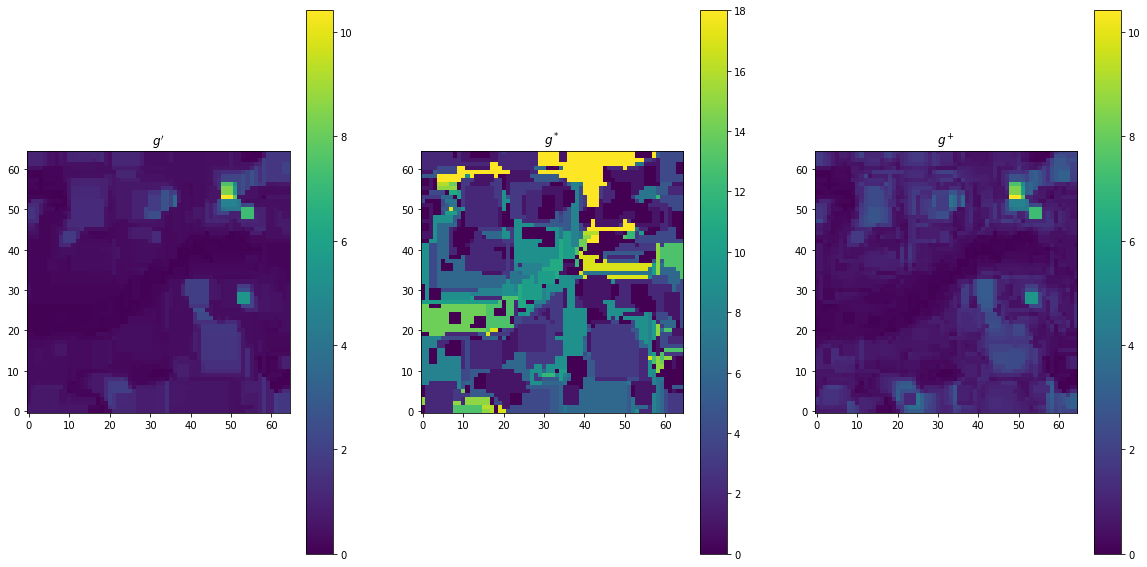

In [66]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(gprime, origin='lower'); plt.colorbar(); plt.title('$g^{\prime}$')
plt.subplot(1,3,2); plt.imshow(gstar, origin='lower'); plt.colorbar(); plt.title('$g^*$')
plt.subplot(1,3,3); plt.imshow(gplus, origin='lower'); plt.colorbar(); plt.title('$g^+$')

In [67]:
T = k * gstar + n
Sg = gprime < n

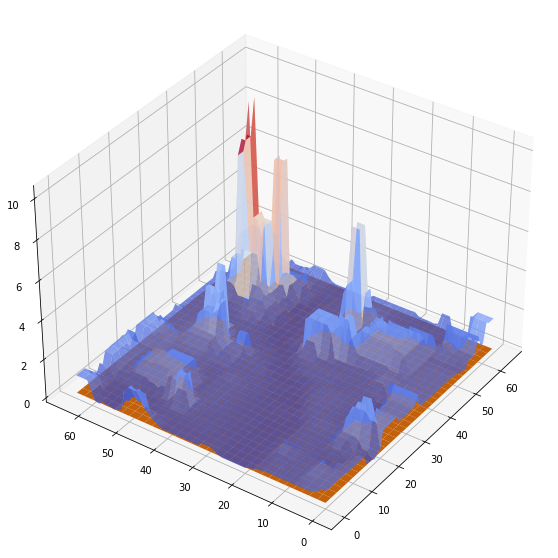

In [123]:
nx,ny =gprime.shape
x = range(nx)
y = range(ny)
hs = np.ones((65,65))
hs.fill(n)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,gprime,cmap=cm.coolwarm,alpha=0.75)
ha.plot_surface(X,Y,hs,alpha=1)

In [124]:
F = cz.copy()
F[np.where(Sg==0)] = np.nan

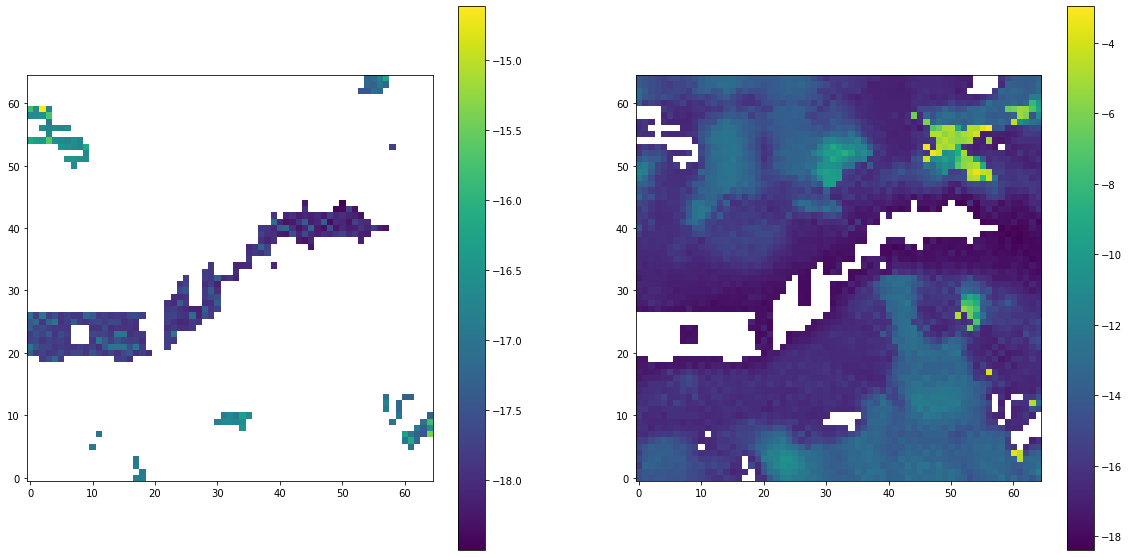

In [125]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.imshow(F, origin='lower'); plt.colorbar();
nonGround = cz.copy()
nonGround[np.where(Sg==1)] = np.nan
plt.subplot(1,2,2); plt.imshow(nonGround, origin='lower'); plt.colorbar();

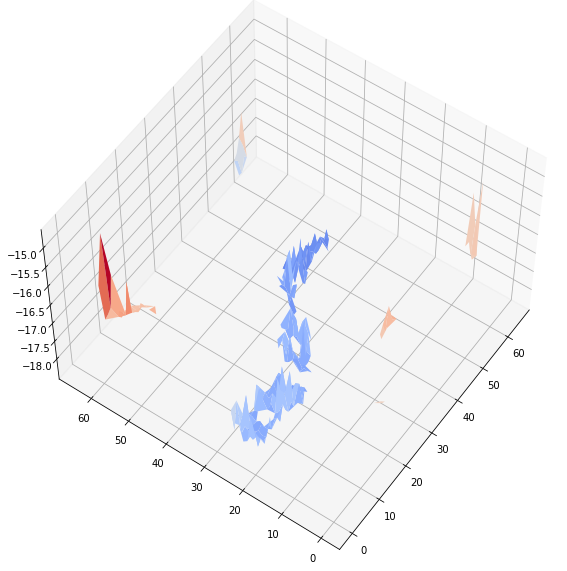

In [126]:
nx,ny =F.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(55, 215)
ha.plot_surface(X,Y,F,cmap=cm.coolwarm)

In [71]:
G = idw(F)

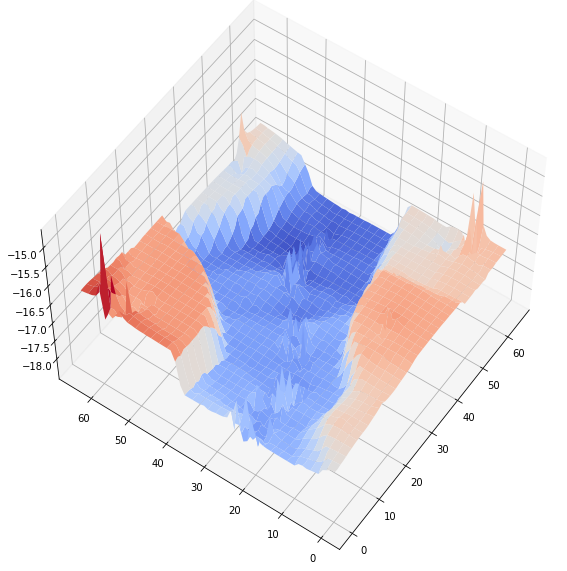

In [104]:
nx,ny =G.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(55, 215)
ha.plot_surface(X,Y,G,cmap=cm.coolwarm)

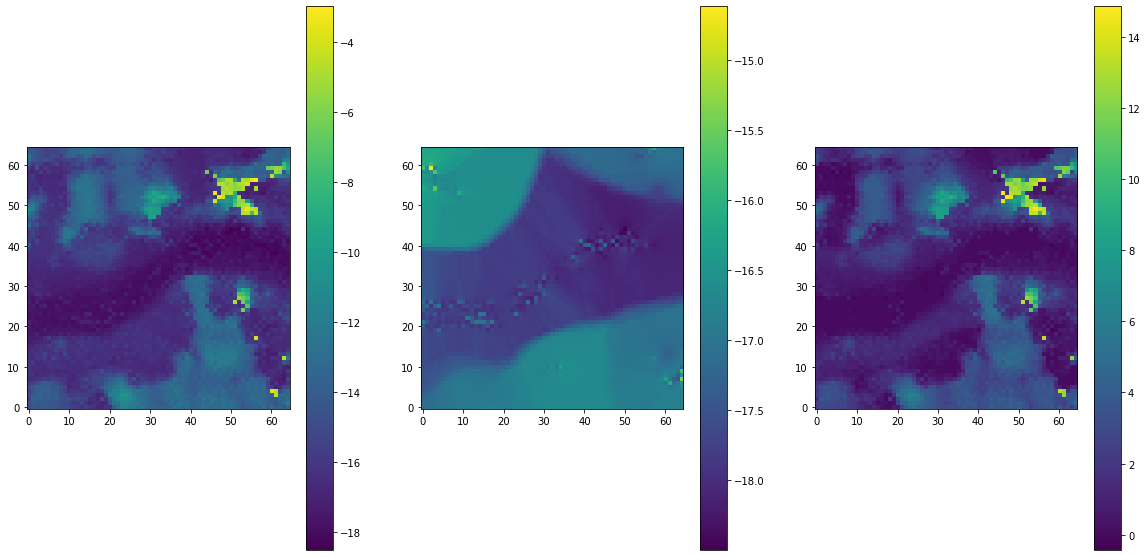

In [73]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(G, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-G, origin='lower'); plt.colorbar();

In [74]:
%%time
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
gradDTM = morphology.grey_dilation(G, structure=struct)

Wall time: 0 ns


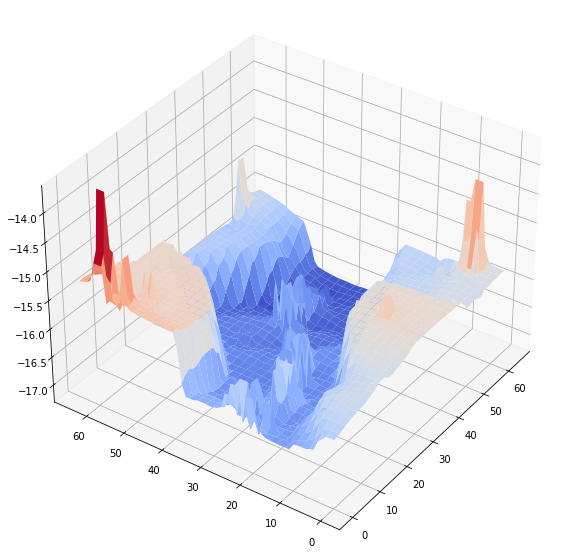

In [75]:
nx,ny =gradDTM.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,gradDTM,cmap=cm.coolwarm)

look for scipy.interpolate.griddata

In [134]:
interpgradDTM = interpolate.griddata(X,Y,gradDTM,method='nearest')

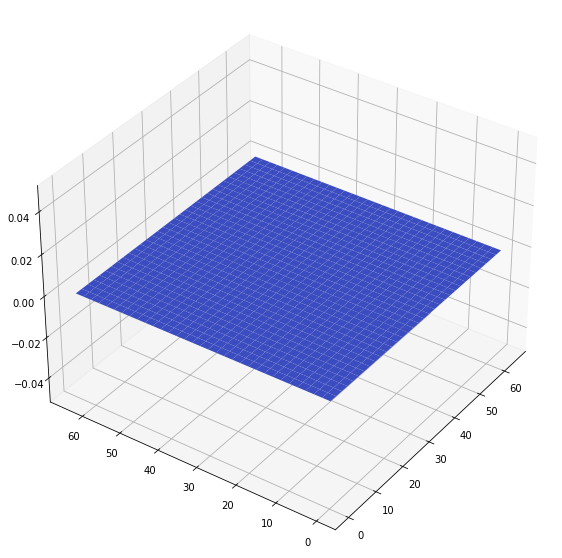

In [130]:
nx,ny =interpgradDTM.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,interpgradDTM,cmap=cm.coolwarm)

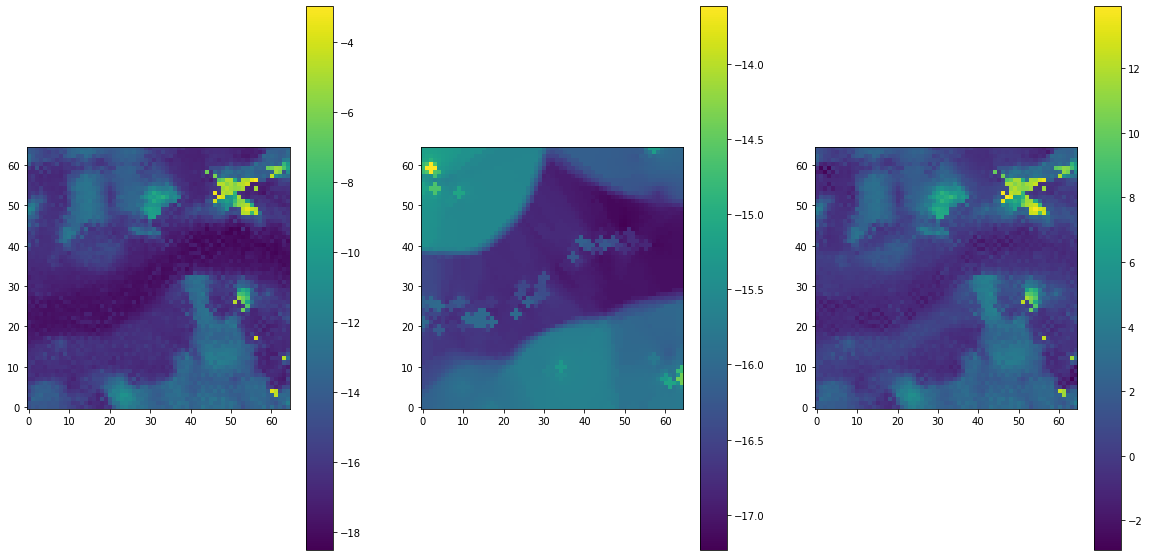

In [76]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(gradDTM, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-(gradDTM+b), origin='lower'); plt.colorbar();

In [77]:
%%time
xbins = np.digitize(df3D.X, xi)
ybins = np.digitize(df3D.Y, yi)
nonground = np.where(df3D.Z >= gradDTM[ybins-1, xbins-1]+b)
ground = np.where(df3D.Z < gradDTM[ybins-1, xbins-1]+b)

Wall time: 976 µs


In [78]:
print("Detected", len(ground[0]), "ground and", len(nonground[0]), "non-ground points")

Detected 1587 ground and 3586 non-ground points


In [79]:
%%time
g = df3D.iloc[ground]
ng = df3D.iloc[nonground]

Wall time: 466 µs


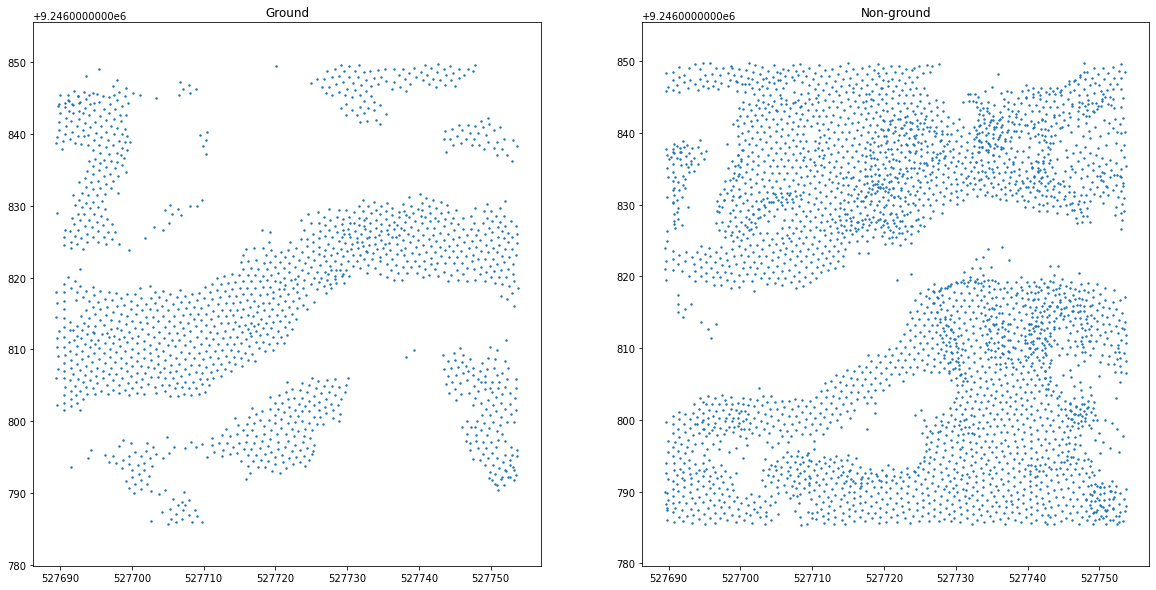

In [80]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.scatter(g.X, g.Y, s=2); plt.title('Ground'); plt.axis('equal');
plt.subplot(1,2,2); plt.scatter(ng.X, ng.Y, s=2); plt.title('Non-ground'); plt.axis('equal');

(527686.2565118, 527756.9535162, 9246782.5214769, 9246852.8884791)

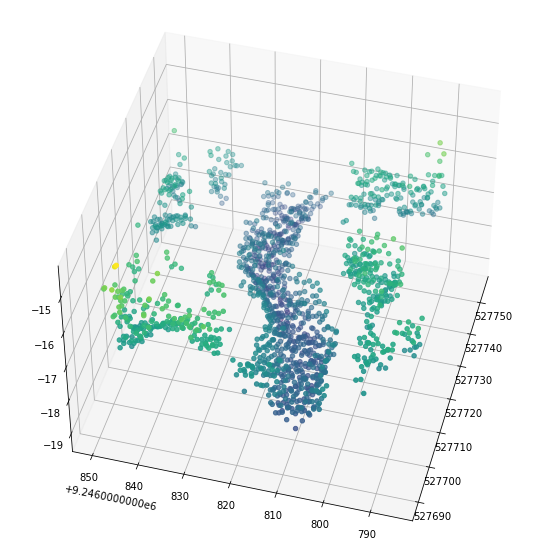

In [101]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(g.X, g.Y, g.Z, c=g.Z, cmap='viridis')
ax.view_init(45, 195)

ax.axis('tight')

In [82]:
cls[ground] = 2 #set ground points to 2
len(cls[ground]) #number of ground points

1587

In [83]:
output = p.arrays[0]
output['Classification'] =cls

In [84]:
#include only ground points
pipeline = pdal.Filter.range(limits="Classification[2:2]").pipeline(output)
print(pipeline.execute())

1587


In [85]:
#default Progressive morphological filter stacked to catch stragglers (havent'tested with alt parameters)
#need to test with alt smrf
pmf_arr = pipeline.arrays[0]
p = pdal.Filter.pmf().pipeline(pmf_arr) | pdal.Filter.range(limits="Classification[2:2]").pipeline()
print(p.execute())

1151


In [86]:
#convert X,Y, and Z data to a pandas dataframe
dfvis2 = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

(527686.2670223, 527756.9530157, 9246782.743476849, 9246852.846480152)

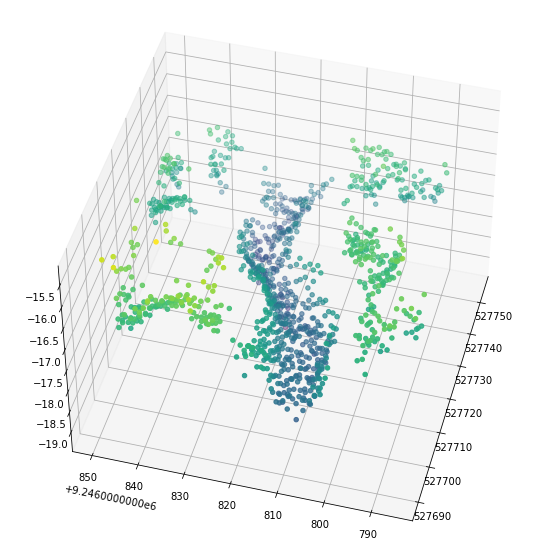

In [102]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(dfvis2.X, dfvis2.Y, dfvis2.Z, c=dfvis2.Z, cmap='viridis')
ax.view_init(45, 195)

ax.axis('tight')

look for a way to drape the orthophoto over the processessed point cloud in python